<a href="https://colab.research.google.com/github/s-feinstein/G2Net/blob/dev/G2Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [G2Net](https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/) – Detecting Continuous Gravitational Waves

**Objective:**
Help us detect long-lasting gravitational-wave signals!

The goal of this competition is to find continuous gravitational-wave signals. You will develop a model sensitive enough to detect weak yet long-lasting signals emitted by rapidly-spinning neutron stars within noisy data.

**Secret Objective!!!** Receive excellent marks from this final project in [3253 - Machine Learning at U. Toronto](https://learn.utoronto.ca/programs-courses/courses/3253-machine-learning)

## Authenticate with Secrets (Obsolete: Style Points Only)
I switched from Google Colab to Kaggle notebooks because the dataset was (much) too large for Colab, so this part isn't actually necessary anymore. Kaggle offers the data directly so there's no need to authenticate with an API token. However it was neat enough I left it in, and it would be useful if I needed to manage other secrets in the future.

> !wget -q -N "https://raw.githubusercontent.com/s-feinstein/G2Net/dev/setup-colab.py"
>
> %run setup-colab.py

## Import the dataset (Also Obsolete when running on the Kaggle platform)


> !pip install kaggle
>
> !kaggle competitions download g2net-detecting-continuous-gravitational-waves

## Load the labels

Load the labels and split it into train and test

In [21]:
import pandas as pd
labels = pd.read_csv('../input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')

# Removing the negative labels
labels = labels[labels.target>=0]
# train_labels.target.value_counts()
# train_labels.info()

# Split Data
from sklearn.model_selection import train_test_split
#train test split
train_labels, test_labels = train_test_split(labels, test_size=0.3, random_state=42)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 108 to 102
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      420 non-null    object
 1   target  420 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.8+ KB


## Generate list of the training file paths

In [22]:
import os

train_files = []
train_path = "/kaggle/input/g2net-detecting-continuous-gravitational-waves/train"
for id in train_labels.loc[:,"id"]:
    filename = id + ".hdf5"
    path = os.path.join(train_path, filename)
    train_files.append(path)
    
train_files[0]

'/kaggle/input/g2net-detecting-continuous-gravitational-waves/train/2688e48bd.hdf5'

# Explore the data

In [23]:
import h5py
file = h5py.File(train_files[0])

print(list(file.keys())[0])
print(file['2688e48bd'].keys())
print(file['2688e48bd']['H1'].keys())
print(file['2688e48bd']['L1'].keys())
print(file['2688e48bd']['frequency_Hz'])
print(file['2688e48bd']['frequency_Hz'][0:4])
print(file['2688e48bd']['H1']['timestamps_GPS'])
print(file['2688e48bd']['H1']['timestamps_GPS'][0], " - ", file['2688e48bd']['H1']['timestamps_GPS'][-1])
print(file['2688e48bd']['H1']['SFTs'])
print(file['2688e48bd']['H1']['SFTs'][0:2])
print(file['2688e48bd']['L1']['timestamps_GPS'])
print(file['2688e48bd']['L1']['timestamps_GPS'][0], " - ", file['2688e48bd']['L1']['timestamps_GPS'][-1])
print(file['2688e48bd']['L1']['SFTs'])
print(file['2688e48bd']['L1']['SFTs'][0:2])

2688e48bd
<KeysViewHDF5 ['H1', 'L1', 'frequency_Hz']>
<KeysViewHDF5 ['SFTs', 'timestamps_GPS']>
<KeysViewHDF5 ['SFTs', 'timestamps_GPS']>
<HDF5 dataset "frequency_Hz": shape (360,), type "<f8">
[306.92055556 306.92111111 306.92166667 306.92222222]
<HDF5 dataset "timestamps_GPS": shape (4564,), type "<i8">
1238170479  -  1248546822
<HDF5 dataset "SFTs": shape (360, 4564), type "<c8">
[[-4.5731778e-23+1.18721092e-22j  2.8206372e-23-1.11619598e-23j
   1.1124856e-22-3.01264718e-23j ... -9.1336872e-23-1.15372359e-22j
   4.9273540e-23+8.50121319e-23j -2.2122217e-22+7.59737612e-23j]
 [-4.5931660e-23-1.34403698e-22j  2.4227980e-23+1.09901059e-22j
   1.7774413e-22-1.22264384e-23j ... -9.4565130e-23+2.65873464e-22j
  -4.0620313e-23-4.09678061e-23j -7.8723440e-23-4.63299556e-23j]]
<HDF5 dataset "timestamps_GPS": shape (4646,), type "<i8">
1238167882  -  1248558232
<HDF5 dataset "SFTs": shape (360, 4646), type "<c8">
[[ 2.2248422e-22+5.95424828e-23j -1.1790475e-22-6.16426640e-23j
   6.1226429e-23+

## Load the data into a dataframe

In [25]:
# https://www.kaggle.com/code/maharshipandya/g2net-data-and-augmentation

import numpy as np
BASE_DIR = "/kaggle/input/g2net-detecting-continuous-gravitational-waves/train/"

class SFT2Img:
    def __init__(self, labels):
        # labels the dataframe of train labels
        self.labels = labels
            
    
    def __getitem__(self, index):
        # get the file id from dataframe
        lab = self.labels.iloc[index]
        file_id = lab["id"]
        
        # this is our label
        y = np.float32(lab["target"])
        
        # SFT tensor for H1 and L1 observatory (128 columns)
        img = np.empty((2, 360, 128), dtype=np.float32)
        
        filename = f"{file_id}.hdf5"
        with h5py.File(BASE_DIR + filename, 'r') as f:
            group = f[file_id]
            
            for i, obs in enumerate(['H1', 'L1']):
                # scaling the fourier transforms (complex64 in nature)
                sft = group[obs]['SFTs'][:, :4096] * 1e22
                
                # magnitude squared
                mag = sft.real ** 2 + sft.imag ** 2
                
                # normalize and reduce 4096 to 128
                mag /= np.mean(mag)
                mag = np.mean(mag.reshape(360, 128, 32), axis=2)
                
                # 0 for H1 and 1 for L1
                img[i] = mag
        
        return img, y

# Added a minor improvement to flatten images to instance variables
# for easier model training
class Dataset:
    def __init__(self, labels):
        self.sft2img = SFT2Img(labels)
        # labels the dataframe of train labels
        self.labels = self.sft2img.labels
        self.H1 = np.ndarray(shape=(0, 360*128))
        self.L1 = np.ndarray(shape=(0, 360*128))
        self.build_data()
        self.H1L1 = np.vstack((self.H1, self.L1))
        self.labelsH1L1 = pd.concat([self.labels, self.labels])
        
    def build_data(self):
        for i in range(self.sft2img.labels.target.shape[0]):
            img, label = self.sft2img[i]
            H1img = np.array(img[0]).flatten()
            L1img = np.array(img[1]).flatten()
            self.H1 = np.vstack((self.H1, H1img))
            self.L1 = np.vstack((self.L1, L1img))
        

In [7]:
train_dataset = Dataset(train_labels)
test_dataset = Dataset(test_labels)
            
print("Shape of the labels: ", train_dataset.labels.target.shape)
print("Shape of H1: ", train_dataset.H1.shape)
print("Shape of L1: ", train_dataset.L1.shape)
print("Shape of the test labels: ", test_dataset.labels.target.shape)
print("Shape of test H1: ", test_dataset.H1.shape)
print("Shape of test L1: ", test_dataset.L1.shape)

Shape of the labels:  (420,)
Shape of H1:  (420, 46080)
Shape of L1:  (420, 46080)


## Model Evaluation

Simple model evaluation for consistent testing and comparison as we try different approaches

In [6]:
# Lots of evaluation functions out there, but kind of fun to code my own
class Performance():
    def __init__(self, model, dataset, H1=True, L1=True):
        self.truePos = 0
        self.trueNeg = 0
        self.falsePos = 0
        self.falseNeg = 0
        self.precision = 0
        self.recall = 0
        self.harmonicMean = 0
        self.model = model
        self.dataset = dataset
        self.H1 = H1
        self.L1 = L1
        self.calculate()
        
    def predict_scores(self):
        for i in range(self.dataset.labels.target.shape[0]):
            actual = self.dataset.labels.target.iloc[i]
            if self.H1:
                predictedI = self.model.predict([self.dataset.H1[i]])
                self.compare_scores(predictedI, actual)
            if self.L1:
                predictedL = self.model.predict([self.dataset.L1[i]])
                self.compare_scores(predictedL, actual)
        
    def compare_scores(self, predicted, actual):
        if predicted == actual:
            if predicted >= 0.5:
                self.truePos += 1
            elif predicted < 0.5:
                self.trueNeg += 1
            else:
                print("Not sure what to do with ", predicted, " and ", actual)
        else:
            if predicted >= 0.5:
                self.falsePos += 1
            elif predicted < 0.5:
                self.falseNeg += 1
            else:
                print("Not sure what to do with ", predicted, " and ", actual) 
        return
        # Fill this in later, compare each score to tally TP/FP/TN/FN

    # Precision: TP / (TP + FP)        
    def calculate_precision(self):
        self.precision = self.truePos / ( self.truePos + self.falsePos)
        return self.precision

    # Recall: TP / (TP + FN)
    def calculate_recall(self):
        self.recall = self.truePos / ( self.truePos + self.falseNeg)
        return self.recall
    
    # Harmonic Mean: F1 = TP / (TP + ((FN + FP)/ 2) ) = 2 * ( (Precision * Recall) / (Precision + Recall) )
    def calculate_harmonic_mean(self):
        self.harmonicMean = 2 * ( (self.precision * self.recall) / (self.precision + self.recall) )
        return self.harmonicMean
    
    # Print the results
    def get_results(self):
        print("True Positives: ", self.truePos)
        print("True Negatives: ", self.trueNeg)
        print("False Positives: ", self.falsePos)
        print("False Negatives: ", self.falseNeg)
        print("Precision: ", self.precision)
        print("Recall: ", self.recall)
        print("Harmonic Mean: ", self.harmonicMean)
        
    # Calculate pipeline
    def calculate(self):
        self.predict_scores()
        self.calculate_precision()
        self.calculate_recall()
        self.calculate_harmonic_mean()
        self.get_results()   

# Train Machine Learning Models

There's a lot of data engineering we can try with this in terms of data transformations, data alignment and normalization, selectively excluding data, etc.
But first, let's take a naive approach and see how a few basic models fare.
That way we can see if future optimizations work and how well.

## Train a basic Stoachastic Gradient Descent Classifier model

In [7]:
from sklearn.linear_model import SGDClassifier
import numpy as np

# Stochastic gradient descent classifier
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(train_dataset.H1, train_dataset.labels.target)

print("~~~")
print("Train H1:")
print("~~~")
Performance(sgd_clf, train_dataset, True, False)
print("~~~")
print("Test H1:")
print("~~~")
Performance(sgd_clf, test_dataset, True, False)
print("~~~")
print("Test L1:")
print("~~~")
Performance(sgd_clf, test_dataset, False, True)

~~~
Train H1:
~~~
True Positives:  279
True Negatives:  141
False Positives:  0
False Negatives:  0
Precision:  1.0
Recall:  1.0
Harmonic Mean:  1.0
~~~
Test H1:
~~~
True Positives:  57
True Negatives:  30
False Positives:  29
False Negatives:  64
Precision:  0.6627906976744186
Recall:  0.47107438016528924
Harmonic Mean:  0.5507246376811594
~~~
Test L1:
~~~
True Positives:  56
True Negatives:  29
False Positives:  30
False Negatives:  65
Precision:  0.6511627906976745
Recall:  0.4628099173553719
Harmonic Mean:  0.5410628019323672


## Train a Support Vector Machine classifier model

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score

svm_clf = SVC(kernel="poly",degree=3, C=float("inf"), coef0=1)
svm_clf.fit(train_dataset.H1, train_dataset.labels.target)

# print(svm_clf.predict(train_dataset.H1))
test_pred = svm_clf.predict(test_dataset.H1)
print(test_pred)

print(precision_score(test_dataset.labels.target, test_pred))
print(recall_score(test_dataset.labels.target, test_pred))
# Assigns 1 to everything

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.6722222222222223
1.0


## Train a Random Forest classifier Model

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(train_dataset.H1, train_dataset.labels.target)

y_pred_rf = rnd_clf.predict(test_dataset.H1)
print(y_pred_rf)

print("Accuracy of RF classifier on train dataset is:",accuracy_score(train_dataset.labels.target, rnd_clf.predict(train_dataset.H1)))
print("Accuracy of RF classifier on test dataset is:",accuracy_score(test_dataset.labels.target, y_pred_rf))
# Assigns 1 to everything

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(train_dataset.H1L1, train_dataset.labelsH1L1.target)

y_pred_bg = bag_clf.predict(test_dataset.H1)
print("Accuracy of Bagging classifier on test dataset is:", accuracy_score(test_dataset.labels.target, y_pred_bg))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy of RF classifier on train dataset is: 1.0
Accuracy of RF classifier on test dataset is: 0.6722222222222223
Accuracy of Bagging classifier on test dataset is: 0.6722222222222223


## Train a neural network 
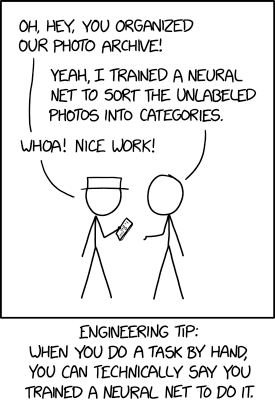

Let's start with a 2 node softmax function

Epoch 1/10
14/14 [==============================] - 2s 129ms/step - loss: 0.6611 - accuracy: 0.6262 - f1_m: 0.8084 - precision_m: 0.6853 - recall_m: 1.0000 - val_loss: 0.9097 - val_accuracy: 0.6722 - val_f1_m: 0.7979 - val_precision_m: 0.6740 - val_recall_m: 1.0000
Epoch 2/10
14/14 [==============================] - 1s 101ms/step - loss: 0.6672 - accuracy: 0.6690 - f1_m: 0.7989 - precision_m: 0.6696 - recall_m: 1.0000 - val_loss: 0.6439 - val_accuracy: 0.6722 - val_f1_m: 0.7979 - val_precision_m: 0.6740 - val_recall_m: 1.0000
Epoch 3/10
14/14 [==============================] - 1s 98ms/step - loss: 0.6570 - accuracy: 0.6381 - f1_m: 0.7873 - precision_m: 0.6540 - recall_m: 1.0000 - val_loss: 0.6700 - val_accuracy: 0.6722 - val_f1_m: 0.7979 - val_precision_m: 0.6740 - val_recall_m: 1.0000
Epoch 4/10
14/14 [==============================] - 1s 98ms/step - loss: 0.6352 - accuracy: 0.6643 - f1_m: 0.8007 - precision_m: 0.6696 - recall_m: 1.0000 - val_loss: 0.6566 - val_accuracy: 0.6722 - val_

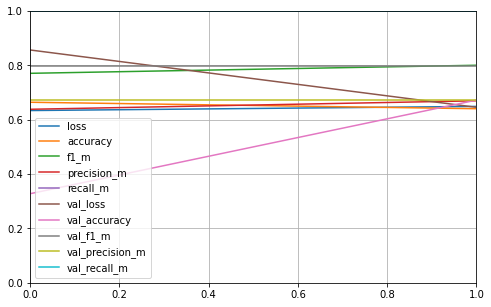

In [18]:
import tensorflow as tf
from tensorflow import keras  # tf.keras
import matplotlib as mpl
import matplotlib.pyplot as plt

# Nice little precision/recall/F1 for keras from:
# https://datascience.stackexchange.com/a/45166
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


nn_clf = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[46080]),
    keras.layers.Dense(900, activation="relu"),
    keras.layers.Dense(400, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

nn_clf.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy", f1_m, precision_m, recall_m])

# Round 1
history = nn_clf.fit(train_dataset.H1, train_dataset.labels.target, epochs=10,
                    validation_data=(test_dataset.H1, test_dataset.labels.target))

nn_clf.evaluate(test_dataset.H1, test_dataset.labels.target)

# Round 2
history = nn_clf.fit(train_dataset.H1, train_dataset.labels.target, epochs=10,
                    validation_data=(test_dataset.H1, test_dataset.labels.target))

nn_clf.evaluate(test_dataset.H1, test_dataset.labels.target)

def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [11]:
train_proba = nn_clf.predict([train_dataset.H1])
test_proba = nn_clf.predict([test_dataset.H1])
print(train_proba.argmax(axis=1))
print(test_proba.argmax(axis=1))
print(test_proba.max(axis=1).round(2))
# So it's predicting 1 for every single answer. That's no good.

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

## Neural network with Sigmoid Function

Epoch 1/10
14/14 [==============================] - 2s 116ms/step - loss: 0.7043 - accuracy: 0.6310 - val_loss: 0.6439 - val_accuracy: 0.6722
Epoch 2/10
14/14 [==============================] - 1s 93ms/step - loss: 0.6484 - accuracy: 0.6643 - val_loss: 0.6388 - val_accuracy: 0.6722
Epoch 3/10
14/14 [==============================] - 2s 127ms/step - loss: 0.6428 - accuracy: 0.6643 - val_loss: 0.6600 - val_accuracy: 0.6722
Epoch 4/10
14/14 [==============================] - 2s 106ms/step - loss: 0.6389 - accuracy: 0.6643 - val_loss: 0.6377 - val_accuracy: 0.6722
Epoch 5/10
14/14 [==============================] - 1s 92ms/step - loss: 0.6296 - accuracy: 0.6643 - val_loss: 0.6427 - val_accuracy: 0.6722
Epoch 6/10
14/14 [==============================] - 1s 93ms/step - loss: 0.6360 - accuracy: 0.6643 - val_loss: 0.6561 - val_accuracy: 0.6722
Epoch 7/10
14/14 [==============================] - 1s 93ms/step - loss: 0.6454 - accuracy: 0.6643 - val_loss: 0.6707 - val_accuracy: 0.6722
Epoch 8/10

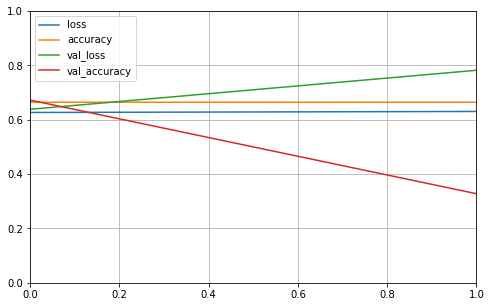

In [12]:
nn_clf = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[46080]),
    keras.layers.Dense(900, activation="relu"),
    keras.layers.Dense(400, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

nn_clf.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

# Round 1
history = nn_clf.fit(train_dataset.H1, train_dataset.labels.target, epochs=10,
                    validation_data=(test_dataset.H1, test_dataset.labels.target))

nn_clf.evaluate(test_dataset.H1, test_dataset.labels.target)

# Round 2
history = nn_clf.fit(train_dataset.H1, train_dataset.labels.target, epochs=10,
                    validation_data=(test_dataset.H1, test_dataset.labels.target))

nn_clf.evaluate(test_dataset.H1, test_dataset.labels.target)

def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [13]:
test_proba = nn_clf.predict([test_dataset.H1])
print(test_proba.argmax(axis=1))
print(test_proba.max(axis=1).round(2))
# Now it's predicting 0 for every single answer. Also not good. 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.73 0.73 0.74 0.71 0.71 0.71 0.72 0.72 0.71 0.73 0.73 0.73 0.72 0.72
 0.71 0.73 0.74 0.71 0.72 0.72 0.74 0.7  0.73 0.72 0.72 0.72 0.72 0.72
 0.71 0.74 0.74 0.72 0.74 0.71 0.74 0.74 0.73 0.7  0.7  0.71 0.73 0.72
 0.73 0.7  0.73 0.72 0.71 0.73 0.74 0.71 0.69 0.71 0.73 0.71 0.72 0.74
 0.71 0.71 0.72 0.72 0.72 0.71 0.72 0.73 0.72 0.72 0.72 0.69 0.73 0.7
 0.73 0.71 0.68 0.73 0.73 0.72 0.74 0.71 0.71 0.71 0.71 0.7  0.71 0.73
 0.72 0.74 0.74 0.71 0.74 0.71 0.72 0.72 0.7  0.73 0.71 0.72 0.72 0.73
 0.73 0.73 0.73 0.7  0.74 0.74 0.71 0.7  0.72 0.7  0.7  0.72 0.75 0.72
 0.72 0.71 0.73 0.72 0.72 0.72 0.74 0.73 0.72 0.74 0.72 0.74 0.73 0

# So far we've succeeded...
## ...in making models that assure us every single sample has the gravity waves we're looking for

It seems like we're not getting very good signal/noise ratio in our data. Let's make some attempts to improve this.

Time to stir the pile

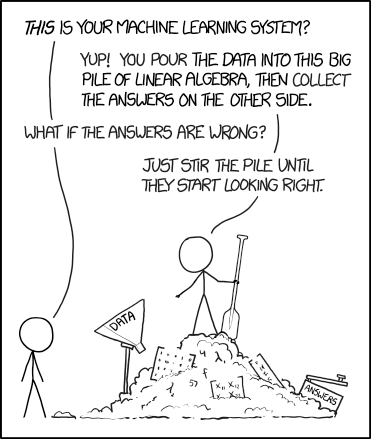

## First lets augment our data

We're going to transform the data by
1. horizontally flip
2. vertically flip
3. horizontally flip + vertically flip

### to 4x our data. 

We'll also start using data from *both* LIGO Hanford & LIGO Livingston labs. Previously we'd only used one, to verify that the data wasn't so different that training separate models for each was more effective.

### to 8x our data.

In [28]:
class AugmentedDataset():
    def __init__(self, labels):
        self.sft2img = SFT2Img(labels)
        # labels the dataframe of train labels
        self.labels = self.sft2img.labels
        self.H1 = np.ndarray(shape=(0, 360*128))
        self.L1 = np.ndarray(shape=(0, 360*128))
        self.augData = np.ndarray(shape=(0, 360*128))
        self.augLabels = np.ndarray(shape=(0))
        self.build_data()
        
    # Function for data augmentation (flip / shift)
    def augment(self, image, hflip=False, vflip=False, vshift=0):
        """
        Params

        image: np.array(2, 360, 128): Apply the transformation to this image
        vflip: Boolean for vertical flip
        hflip: Boolean for horizontal flip
        vshift: Shift amount in the vertical direction
        """
        new_img = np.array(image, copy=True)

        if hflip:
            new_img[0] = np.fliplr(new_img[0])
            new_img[1] = np.fliplr(new_img[1])

        if vflip:
            new_img[0] = np.flipud(new_img[0])
            new_img[1] = np.flipud(new_img[1])

        if isinstance(vshift, int):
            if vshift != 0:
                new_img[0] = np.roll(new_img[0], vshift, axis=0)
                new_img[1] = np.roll(new_img[1], vshift, axis=0)
        if not isinstance(vshift, int):
            print("Error: vshift expects an int or tuple of ints")
            return

        return new_img

    def build_data(self):
        for i in range(self.sft2img.labels.target.shape[0]):
            img, label = self.sft2img[i]
            img_hflip = np.array(self.augment(img, True, False))
            img_vflip = np.array(self.augment(img, False, True))
            img_hvflip = np.array(self.augment(img, True, True))
            H1img = np.array(img[0]).flatten()
            L1img = np.array(img[1]).flatten()
            self.H1 = np.vstack((self.H1, np.array(img[0]).flatten()))
            self.L1 = np.vstack((self.L1, np.array(img[1]).flatten()))
            self.augData = np.vstack((self.augData, 
                                   np.array(img[0]).flatten(), np.array(img_hflip[0]).flatten(), 
                                   np.array(img_vflip[0]).flatten(), np.array(img_hvflip[0]).flatten(), 
                                   np.array(img[1]).flatten(), np.array(img_hflip[1]).flatten(), 
                                   np.array(img_vflip[1]).flatten(), np.array(img_hvflip[1]).flatten()))
            self.augLabels = np.append(self.augLabels, [label, label, label, label,
                                        label, label, label, label])         

In [29]:
aug_train = AugmentedDataset(train_labels)
aug_test = AugmentedDataset(test_labels)
            
print("Shape of the augmented labels: ", aug_train.augLabels.shape)
print("Shape of the augmented data: ", aug_train.augData.shape)
print(aug_train.augLabels[:256])

Shape of the augmented labels:  (3360,)
Shape of the augmented data:  (3360, 46080)
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


# Train Models On Augmented Data
Let's focus on SGD and NN

## Stochastic Gradient Descent classification model with augmented data

In [62]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

# Stochastic gradient descent classifier
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(aug_train.augData, aug_train.augLabels)

# Fit the model with CS=3 and evaluate its performance using accuracy, precision and recall
print("Training score:",cross_val_score(sgd_clf, aug_train.augData, aug_train.augLabels, cv=3, scoring="accuracy"))
print("Test score:",cross_val_score(sgd_clf, aug_test.augData, aug_test.augLabels, cv=3, scoring="accuracy"))
aug_test_predict = cross_val_predict(sgd_clf, aug_test.augData, aug_test.augLabels, cv=10)
print("Test precision: ",precision_score(aug_test.augLabels, aug_test_predict)," Test accuracy: ",accuracy_score(aug_test.augLabels, aug_test_predict))
print("Test F1: ",f1_score(aug_test.augLabels, aug_test_predict, average="weighted")
# Look at results
print(aug_test_predict[:256])

Training score: [0.475      0.52053571 0.53571429]
Test score: [0.47916667 0.5625     0.67291667]
Test precision:  0.708502024291498  Test accuracy:  0.5423611111111111
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


## Hyperparameter tuning for Stochastic Gradient Descent model

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   32.4s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   38.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   42.1s remaining:   42.1s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   48.1s remaining:   28.9s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   49.3s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.0s finished


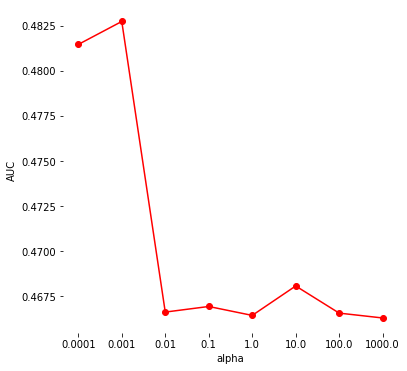

SGDClassifier(alpha=0.001, loss='log', n_jobs=-1) 0.4827323942428911


In [72]:
# Hyperparameter tuning for SGD
# 'alpha' - Learning rate
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
# !pip3 install parfit
import parfit.parfit as pf

grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
           aug_train.augData, aug_train.augLabels, aug_test.augData, aug_test.augLabels, 
           metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  9.2min remaining:  1.8min


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 31.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    6.9s finished


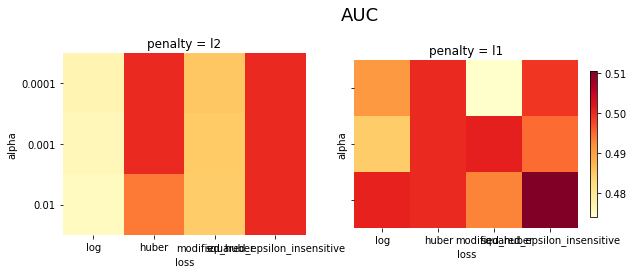

SGDClassifier(alpha=0.01, loss='squared_epsilon_insensitive', n_jobs=-1,
              penalty='l1') 0.5104969183359014
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/metric cannot use predict_proba. Using predict for scoring instead.
This model/

In [73]:
# Hyperparameter tuning for SGD
# 'loss' and 'penalty'
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
# !pip3 install parfit
import parfit.parfit as pf

grid = {
    'alpha': [1e-4, 1e-3, 1e-2], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['log', 'huber', 'modified_huber', 'squared_epsilon_insensitive'], # logistic regression,
    'penalty': ['l2', 'l1'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
           aug_train.augData, aug_train.augLabels, aug_test.augData, aug_test.augLabels, 
           metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  2.5min remaining:  2.5min


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  6.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.6s finished


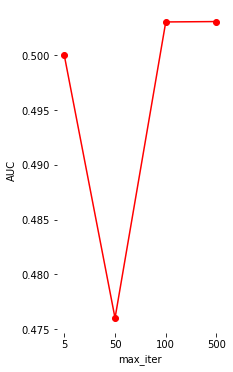

SGDClassifier(alpha=0.001, loss='squared_epsilon_insensitive', max_iter=500,
              n_jobs=-1, penalty='l1') 0.5030904188261661


In [76]:
# Hyperparameter tuning for SGD
# 'max_iter'
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
# !pip3 install parfit
import parfit.parfit as pf

grid = {
    'alpha': [1e-3], # learning rate
    'max_iter': [5, 50, 100, 500], # number of epochs
    'loss': ['squared_epsilon_insensitive'], # logistic regression,
    'penalty': ['l1'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
           aug_train.augData, aug_train.augLabels, aug_test.augData, aug_test.augLabels, 
           metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

In [30]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

# Stochastic gradient descent classifier
sgd_clf = SGDClassifier(alpha=0.01, loss='squared_epsilon_insensitive', n_jobs=-1,
              penalty='l1', max_iter=200, tol=-np.infty, random_state=42)
sgd_clf.fit(aug_train.augData, aug_train.augLabels)

SGDClassifier(alpha=0.01, loss='squared_epsilon_insensitive', max_iter=200,
              n_jobs=-1, penalty='l1', random_state=42, tol=-inf)

In [ ]:
# Fit the model with cv=3 and evaluate its performance using Accuracy, Precision and Recall
print("Training score:",cross_val_score(sgd_clf, aug_train.augData, aug_train.augLabels, cv=3, scoring="accuracy"))
print("Test score:",cross_val_score(sgd_clf, aug_test.augData, aug_test.augLabels, cv=3, scoring="accuracy"))
aug_test_predict = cross_val_predict(sgd_clf, aug_test.augData, aug_test.augLabels, cv=3)
print("Test precision: ",precision_score(aug_test.augLabels, aug_test_predict)," Test accuracy: ",accuracy_score(aug_test.augLabels, aug_test_predict))
print("Test F1: ",f1_score(aug_test.augLabels, aug_test_predict, average="weighted"))

## Neural Network classification model with augmented data

In [19]:
import tensorflow as tf
from tensorflow import keras  # tf.keras
from keras.metrics import Precision, Recall
import matplotlib as mpl
import matplotlib.pyplot as plt

nn_clf = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[46080]),
    keras.layers.Dense(900, activation="relu"),
    keras.layers.Dense(400, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

nn_clf.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy", f1_m, precision_m, recall_m])

# Round 1
history = nn_clf.fit(aug_train.augData, aug_train.augLabels, epochs=10,
                    validation_data=(aug_test.augData, aug_test.augLabels))

nn_clf.evaluate(aug_test.augData, aug_test.augLabels)

# Round 2
history = nn_clf.fit(aug_train.augData, aug_train.augLabels, epochs=10,
                    validation_data=(test_dataset.H1, test_dataset.labels.target))

nn_clf.evaluate(aug_test.augData, aug_test.augLabels)

def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

NameError: name 'aug_train' is not defined

## Hyperparameter tuning for Neural Network model